# Introduction

Public analytics research pertaining to professional football has been united by one idea, NFL teams must throw the football well to win consistently. The slogans "Running Backs Don't Matter" or "Let Russ Cook" made the message loud and clear: passing well is the most important thing an offense can do to score points.

NFL defenses are loading up to stop the pass like never before. "Hybrid safety-linebacker", "Dime package", and "Nickel Corner" are spoken on seemingly every play by the broadcast crews. Not that these positions and packages are new, rather their usage is demanded now more than ever.

The nature of evaluating defense is much more challenging than offense. Particularly at the defensive back position, defense is more anticipatory and reactive than determinant and proactive. Malcolm Butler can not control the Seahawks throwing a slant to Ricardo Lockette. But, he can break on the ball to pick off Russell Wilson for a Super Bowl win.

This underscores the importance of a defender's ability to track a receiver's movement and break on a receiver's cut while eyeing the Quarterback's gaze.

A defender's ability to maintain a close distance to receivers and break on the ball when it's thrown are two of the most important characteristics a team seeks in a starting defensive back. The relationship between these two attributes is crucial. Generally, there are two types of coverage in football - man and zone. They're distinctively different in how they go about stopping an aerial attack. In man, you want your defender to stick to a receiver like glue. In zone, you'll sit back and read the offense's intent then break as fast as possible once the QB winds up.

Focusing on the relationship between being sticky and anticipating where the ball will be thrown allows us to encapsulate a more complete scope of which NFL defensive backs are best in coverage.


# Pass Completion Probability

**Data**

Stopping a pass from being caught is the best thing a defender can do. He can achieve this by not letting the receiver get open and making the QB look elsewhere, breaking aggressively and the receiver "hears his footsteps" which causes a drop, or be within close proximity and knock the ball away.
A variety of features can be taken from the tracking data or derived to capture these scenarios.
All non-traditional passing plays (i.e. fake punts.) were removed. To focus on how a defender positions himself throughout a play the following features were used or calculated to model completion probability:

- Defender distance from the nearest receiver.
- Nearest defender's distance from the line of scrimmage at the time of the snap.
- The Quarterback's speed and acceleration at the time of the throw: Allows us to control for anticipated QB accuracy. A QB on the run is less likely to throw an accurate ball.
- Maximum space available for the play: If the ball is on the 50 yardline there are 60 yards of available space in the X-direction to the back of the endzone.
- Defender and nearest defender distance from the QB.
- Difference in speed between defender and nearest receiver.
- Difference in acceleration between defender and nearest receiver.
- Absolute difference in direction of motion between defender and nearest receiver.
- Rate of change in distance between defender and nearest receiver: Is the defender gaining or losing ground in relation to three frames prior?
- How far in front/behind the nearest receiver is relative to the defender: Focuses just on the X coordinate location of the defender and receiver.
- Whether or not the defender's nearest receiver is the most open receiver.


These inputs create a few clear assumptions that are critical to understanding the results of this analysis. Each of these features are calculated as a single defender's impact on the completion probability to the nearest receiver. Therefore, the objective of the model is not to calculate the perfect completion probability. Rather, it is specifically focusing on one defender's impact on a pass being completed. This assumes the receiver he's nearest to is his responsibility. This assumption can be controlled to an extent by accounting for the amount of time a defender was nearest to each receiver.


The model was trained in [this notebook](https://www.kaggle.com/calvinsmith625/bdb-randomforest).

**Methodology**

Using these features I trained a Random Forest to predict the odds of a pass being completed (xComp). The model achieved a Recall of .84, Precision of .76, F1 Score of .79, AP of .87 for the Precision-Recall Curve, and an AUC of .84 for the ROC Curve. The overall accuracy of the model came out to ~76% of passes predicted correctly on a test set of 1,840 passes. For example, observe the animated play below between the Tennessee Titans and the Houston Texans. At the top of the animation, you'll see Malcolm Butler (no. 21) guarding Will Fuller (no. 15).

In this play, Butler maintains an average completion percentage of 38% throughout the course of all of his coverage, despite speedy Will Fuller running a go route.

Animation credit to [this notebook](https://www.kaggle.com/stefancurtress/animate-plays-in-r).


In [1]:
library(tidyverse)
library(data.table)
#turning off warnings
options(warn=-1)
options(scipen = 999)
#setting plot width and height
options(repr.plot.width=15, repr.plot.height = 10)
game_data <- fread('../input/nfl-big-data-bowl-2021/week2.csv')
game_data <- game_data %>%

filter(gameId == 2018091607 & playId == 3307)

play_data <- fread('../input/nfl-big-data-bowl-2021/plays.csv')

comp_prob <- fread('../input/bdb-randomforest/comp_prob_dat.csv',
                  drop='V1')
comp_prob <- comp_prob %>% select(nflId, gameId, playId, frameId, comp_prob)

plot <- left_join(game_data,
          comp_prob,
          by=c('gameId', 'playId', 'frameId', 'nflId'))

plot <- left_join(plot,
                 play_data,
                 by=c('gameId', 'playId'))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
generate_play = function(df, game, play){
    
    one_play = df %>% filter(gameId == game & playId == play)    
    one_play_summary = df %>% filter(gameId == game, playId == play)

    description = one_play_summary$playDescription[1]

    one_play_for_plot = one_play
    one_play_for_plot$time = format(one_play_for_plot$time, format = "%Y-%m-%d %H:%M:%OS3")

    one_play_for_plot_home =  one_play_for_plot %>% filter(team == 'home') 
    one_play_for_plot_away =  one_play_for_plot %>% filter(team == 'away')
    one_play_for_plot_ball =  one_play_for_plot %>% filter(team == 'football') 
    
    # specify where the extra markings should go
    x_markings = seq(from = 11, to = 109, by = 1)
    x_markings = x_markings[x_markings %% 5 != 0]

    y_bottom = rep(1, length(x_markings))
    y_lower_mid = rep(18, length(x_markings))
    y_upper_mid = rep(53.3-18, length(x_markings))
    y_top = rep(53.3 - 1, length(x_markings))
    
    # specify where the numbers should go
    numbers_x = seq(from = 20, to = 100, by = 10)
    numbers_bottom_y = rep(3, length(numbers_x))
    numbers_top_y = rep(53.3-3, length(numbers_x))

    # generate the base plot to animate
    base_plot = ggplot(one_play_for_plot_ball, aes(x = x, y = y)) +
      xlim(0,120) + ylim(0, 53.3) +
      theme(panel.background = element_rect(fill='darkgreen', colour='red'),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks =  element_blank(),
            plot.title = element_text(size = 12)) + 
      ggtitle(description) +
      geom_hline(yintercept=0, colour = 'white') +
      geom_hline(yintercept=53.3, colour = 'white') +
      geom_vline(xintercept = 0, colour = 'white') + 
      geom_vline(xintercept = 10, colour = 'white') +
      geom_vline(xintercept = 15, colour = 'white') +
      geom_vline(xintercept = 20, colour = 'white') +
      geom_vline(xintercept = 25, colour = 'white') +
      geom_vline(xintercept = 30, colour = 'white') +
      geom_vline(xintercept = 35, colour = 'white') +
      geom_vline(xintercept = 40, colour = 'white') +
      geom_vline(xintercept = 45, colour = 'white') +
      geom_vline(xintercept = 50, colour = 'white') + 
      geom_vline(xintercept = 55, colour = 'white') +
      geom_vline(xintercept = 60, colour = 'white') +
      geom_vline(xintercept = 65, colour = 'white') +
      geom_vline(xintercept = 70, colour = 'white') +
      geom_vline(xintercept = 75, colour = 'white') +
      geom_vline(xintercept = 80, colour = 'white') +
      geom_vline(xintercept = 85, colour = 'white') +
      geom_vline(xintercept = 90, colour = 'white') +
      geom_vline(xintercept = 95, colour = 'white') +
      geom_vline(xintercept = 100, colour = 'white') +
      geom_vline(xintercept = 105, colour = 'white') +
      geom_vline(xintercept = 110, colour = 'white') +
      geom_vline(xintercept = 120, colour = 'white') +
      geom_rect(aes(xmin = 0.2 , xmax = 9.8, ymin = 0.2, ymax = 53.1) ) + 
      geom_rect(aes(xmin = 110.2 , xmax = 119.8, ymin = 0.2, ymax = 53.1) ) + 
      geom_text(data = data.frame(x = x_markings, y =y_bottom), aes(label = 'l'), color = 'white')+
      geom_text(data = data.frame(x = x_markings, y =y_lower_mid), aes(label = 'l'), colour = 'white') +
      geom_text(data = data.frame(x = x_markings, y =y_upper_mid), aes(label = 'l'), color = 'white') +
      geom_text(data = data.frame(x = x_markings, y =y_top), aes(label = 'l'), color = 'white') + 
      geom_text(data = data.frame(x = 12.5, y = 53.3 / 2.0), aes(label = 'l'), color = 'white', size = 10) + 
      geom_text(data = data.frame(x = 107.5, y = 53.3 / 2.0), aes(label = 'l'), color = 'white', size = 10) + 
      geom_text(data= data.frame(x = numbers_x, y = numbers_bottom_y), aes(label = 50 - abs( 50 - (numbers_x-10) )), colour = 'white', size = 5) +
      geom_text(data= data.frame(x = numbers_x, y = numbers_top_y), aes(label = 50 - abs( 50 - (numbers_x-10) )), colour = 'white', size = 5) +
      geom_point(data = one_play_for_plot_home, aes(x=x,y=y), colour = 'red', size = 5) + 
      geom_point(data = one_play_for_plot_away, aes(x=x,y=y), colour = 'black', size = 5) +
      geom_text(data = one_play_for_plot_home, aes(x = x, y = y, label = jerseyNumber), colour = 'white') +
      geom_text(data = one_play_for_plot_away, aes(x = x, y = y, label = jerseyNumber), colour = 'white') +
      geom_point(colour = 'white', size = 2)


    anim = base_plot  +   transition_states(time,
                                   transition_length = 2, state_length = 1)
    
    
    animate(anim, renderer = magick_renderer(), width = 800, height = 400)
    
    
}
library(ggthemes)
library(gganimate)
library(magick)
generate_play(plot, 2018091607, 3307)

Linking to ImageMagick 6.9.10.23
Enabled features: fontconfig, freetype, fftw, lcms, pango, webp, x11
Disabled features: cairo, ghostscript, rsvg

Using 4 threads



<img src="data:image/gif;base64,R0lGODlhIAOQAfcAAAEBAQsLCwAdABMTExsbGwAiAAArAAAzAAA7ABs7GyMjIywsLDQ0NDw8
PDA7MF8/AGM9AGw6AHc1AHo3AwBDAABMAABTAABcAA1fABNcABtZADlOACxTACRXATJQAABk
AAlgAAdoBwtrCxBuEBZxFh12HRViByR6JCp+KjBxMDlUOUNKAEpHAFhEAnNoMVZ6OENDQ0tL
S1NTU1lZWUJfQmRkZGtra3R0dHx8fGZ5Zk5kTrUdALsbAIwtAJYpAIMxAJMzCK0hAKQkAKE+
GbgvEv8AAP8MDP8TE/8bG8goE/8kJP8rK/8zM/88POQ9MoRIGJNVK6dJJ79UO7RQM7BRM5tZ
MrheQpRrQrdoS610VL56YMtXQ/9DQ/9MTP9XV+xcVM9nVMB+Zf9jY/9ra/9zc/98fOd2bOtg
WMhJNC6ALjODMzmHOT+KP0yBO0ONQ0yIQk2TTUeQR1KWUlaYVlycXFiLVGGeYWWQZXOZc2Sh
ZGula3Oqc3mueX+xf3uhbXqBTLCQcpGNYsqJdIKCgouLi5SUlJubm5afloiZiLydgoS0hIi3
iIy5jJK9kp28nZWqk6SkpKqqqrKysru7u6+wkdOci/+EhP+MjP+Tk/+ZmeKdks6oldi2p9e2
pv+jo/+rq/+7u/+ysue3reGilprBmpfAl6HGoafKp63NranFo7TStLzWvL/Yv7DPsNnHuOLE
ucTExMvLy8LawsneydPT09vb29fSwv/ExP/Kyv/T0//b2+jUy83hzdLk0tjn2N7r3vDj3eTk
5OPu4+vr6//k5P/u7vHr5efw5+vz6/L28v/19PX59f////z49wAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACH5BAQKAAAAIf8LTkVUU0NBUEUyLjADAQAAACwA
AAAAIAOQAQAI/gCZCRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJ
kyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp36sBnV
q1izanVaaBKzWjAGNKhVsAGAszEEBoMRYCyzSJAOdh0GoNBASTAWNgMQbKChvAuTDSgomBkt
Bg9rxRgwQAZZWgsaArAI12CAywEYwCo4o4bAYQHsMoMFYNnByTQnBTB5OOFqh4UxtkY4iADd
ggGsJuz8ObTAWACSCRxwNgCAwQZbz24IK4CCvX0FFko7cFlwi7F3Bxi0tbt3ns0A/i+A1AwH
4IEEai1LZprZ+GU4GjALb5B+sOPRI51PyHfgdIbZCZTMarEg5pAChDSzzCCRQdbQaxTRV9AA
tDSTDCQBxEIQJJExI0kA1BUi32k1DbNZSQXy99AwyF2UIkIBDMMMhAKhlhCHAn1IHSEjMkPh
Qq29mJCMAsEiH3R+7ZfMdRWxSFB0BQ2Cw3dUVjlTIYSMZmAzZM0oSTM0ajlQlzjERRCWzIB2
www5AgaJAo0RKRCSAv012oixjEgIAQQMgtyeBBAy2GyTLDDADFA+WdpAMSQD2Q0KEOAVM2/G
yUwMACzQjCEKKDCIAnf+Jh8tDRASgwKTlokbLQPhwOaY/gDIaAMOA1glw5SFEJAZWZgusIwN
jE35FpwyyEiqqagSFEkNMzDQAKvM5LqrQDUEKxCwAwgrkIO0wIDspJXWYFUkxBrbQHwNTDKD
Aja8xWwDzxpmYKGH9tVrM4USgGhBeyKIXL4yRJfvvpC8G+9AhC6gb18zZGqWpgL1ugy5lg50
n6w4vDaDtj8OZKSozKQ4GyyG7kvquh4D1l+d1AkYa0HSMvBYqadO2q+ghjWwbg2i4XADM4Nw
Z+XQRKcUA6uGxLCuY0UOQ8sADAQAA1lJrxtDl+oWdDQzwQSQDAGSeJhXLQPE0gyzBNG5aV4f
hyzfJATQksxizMBNyzJhyZvm/gCwNHPDfgTpqyHCdTET31dln/3qZLSkl0wDoLadp2EBeGXI
vK8O1PFooAbulQKQbSZp13fX0O6Mby0wTC0B1EJ2LMugTUvllPb4FgAa4kj6r55Fojrrtfi+
eusINxhA2JcbFvcwDBjyejM2sFkLAJvFoCldw0SCO6WRpchi3+bVuPdmfxNkdzJ5f19eXixO
sv7tuXf4G2Lq3zBiAKbZKD7rZqNNULILCB0zJKW5wRUJT6NCTGvUF77ZDaI9o8kLnaLVMmYs
STgWC0DpPDM7y70tbsugmwMnJp7NBK1oKExhSAggHEIAQBLJwIGBfjM1wyHGhTCUoVpmKBAW
pmk1/uRaBl6YQQjPcC1MxQGAcdLSto/ZQGixGMysfjOYFBniVcsIk8VmEIB6GQY5DipibwSy
Gp/lKHII/KJAatGhYPBwRtCiXEFqgINgEIAZN8ABXZLRjL4sY03ie5MBxfhDNRpGfrXTXC36
yIw/skmQA3lTHIunvDVGxoyGmQQhu1ZJwwmLAMGIRI/S05orzuk1kzFlI2k0xZANRpVZZIYq
wfSWUXZJb7B8jdeYoT/UERI0nKnjYG4wiK5h0EfGMQ4kmigfkSFmlqt5WkHadhYlooUgS5JT
I/0IyMZtKzKthMWgkDOgZZBNIFJSoTrXeZHY/KeRLzOIdYbxznmSEZvI/uHkpXCgHzwKbUba
XJks2Taij83AEGoZjAzMFIxBIcZPC4io6urTnlhkrBYOOqQ/BxIjXjKDZ9tCI8gyykbN6YaM
t4RF5yIJA1NOggGRMNAgGOCsxaGTTwkiJked1qGSDiQSmdMM0Giqs/kAKkFEHECgTsqtnkYG
pAPRKRlX1zkcZGmAoQwqLFoDUYnKaDVdjaicFppQoA1AogtIhp8Y4NVIyGAgCziR3sI60V2G
aTVSBShB/uJSmPKwbASRXAJD9tCzejWjKasRlJKGTSYNZKY11ehXIkNWrg1KfjCQBCFOl052
evazDfmaQCZxHsfCYlJ7SQZpT4lBGom2kJYd/kRefkmjCf6nbZKQzxOpyIzdupKw0TLiVw7S
z4E0ABKzCaMRb+PRPJ4xVLWULGJbRMY4uqogrJtBXLJYg5/5ri+QeNVqgiEjkkWCtpL1qUAg
YaBlDCB4CwAvm8gbsgVEgr6xsC8lM+ogHAiLFppdLuM6hAOhgZK9ikxRIYQLrckseEwE8W0U
g4swCm/rLVt670AULNwu7bKXk/llL7um3fkEoLsE2ZyYoutMCxtGsh47kkALoaR4CuS7lGIT
ScEprAkjdsHpEkiBQUvkIhvEh80g4CAKOoxJ/Ei281EyYIKBSGYoQDjAFAghpPZFVtngrQQR
KGNnFwy8yQcW6VmG/gwGAzf1xOCOrWmohpbctIGwqBB8dDJGO+QgslUoejVqRiwcBwNQkdnM
0m1jlTXYyEgAdjREUsDKYnA8CnKtAdTBHyEYkIxkNM/PH9UxnxEJiRc2Y6bRykswME3EBqyn
eZt+NUK/meiQpWcY3gL1lyVr1R6G8oVA6x5iGlohOvNyGXIGmu3a3Ay6JZvOz5aP9sKGaoQN
G7DG/vBJj806L2cOPQGIDlvCBgsZqZjM4RlsiuR86lFVGRYqWyxgyn3BM6m6AW/dcd3S04w1
w5hsLUpnuY1M8M9ubTSGgkF0aLenxkQnvwOo4Wi+fSkN6XM+DHATnGKgTdsCpgaZAaqW/gmg
ABqPvOR5mY0kFiA1soApbBsOi1i8wt8OVSpgApEBAZaRq/EYCOQwFfUaT5e1FGOGAZOa0aRQ
puXrDKMBUItpJC5lm8UMQFyUIl

# A tibble: 100 x 7
   format width height colorspace matte filesize density
   <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
 1 gif      800    400 sRGB       FALSE        0 72x72  
 2 gif      800    400 sRGB       TRUE         0 72x72  
 3 gif      800    400 sRGB       TRUE         0 72x72  
 4 gif      800    400 sRGB       TRUE         0 72x72  
 5 gif      800    400 sRGB       TRUE         0 72x72  
 6 gif      800    400 sRGB       TRUE         0 72x72  
 7 gif      800    400 sRGB       TRUE         0 72x72  
 8 gif      800    400 sRGB       TRUE         0 72x72  
 9 gif      800    400 sRGB       TRUE         0 72x72  
10 gif      800    400 sRGB       TRUE         0 72x72  
# … with 90 more rows

Now observe the predicted completion probabilities from each route. The size of the blue dots (each defender) corresponds to the xComp for the defender's nearest receiver (smaller is better for the defense).

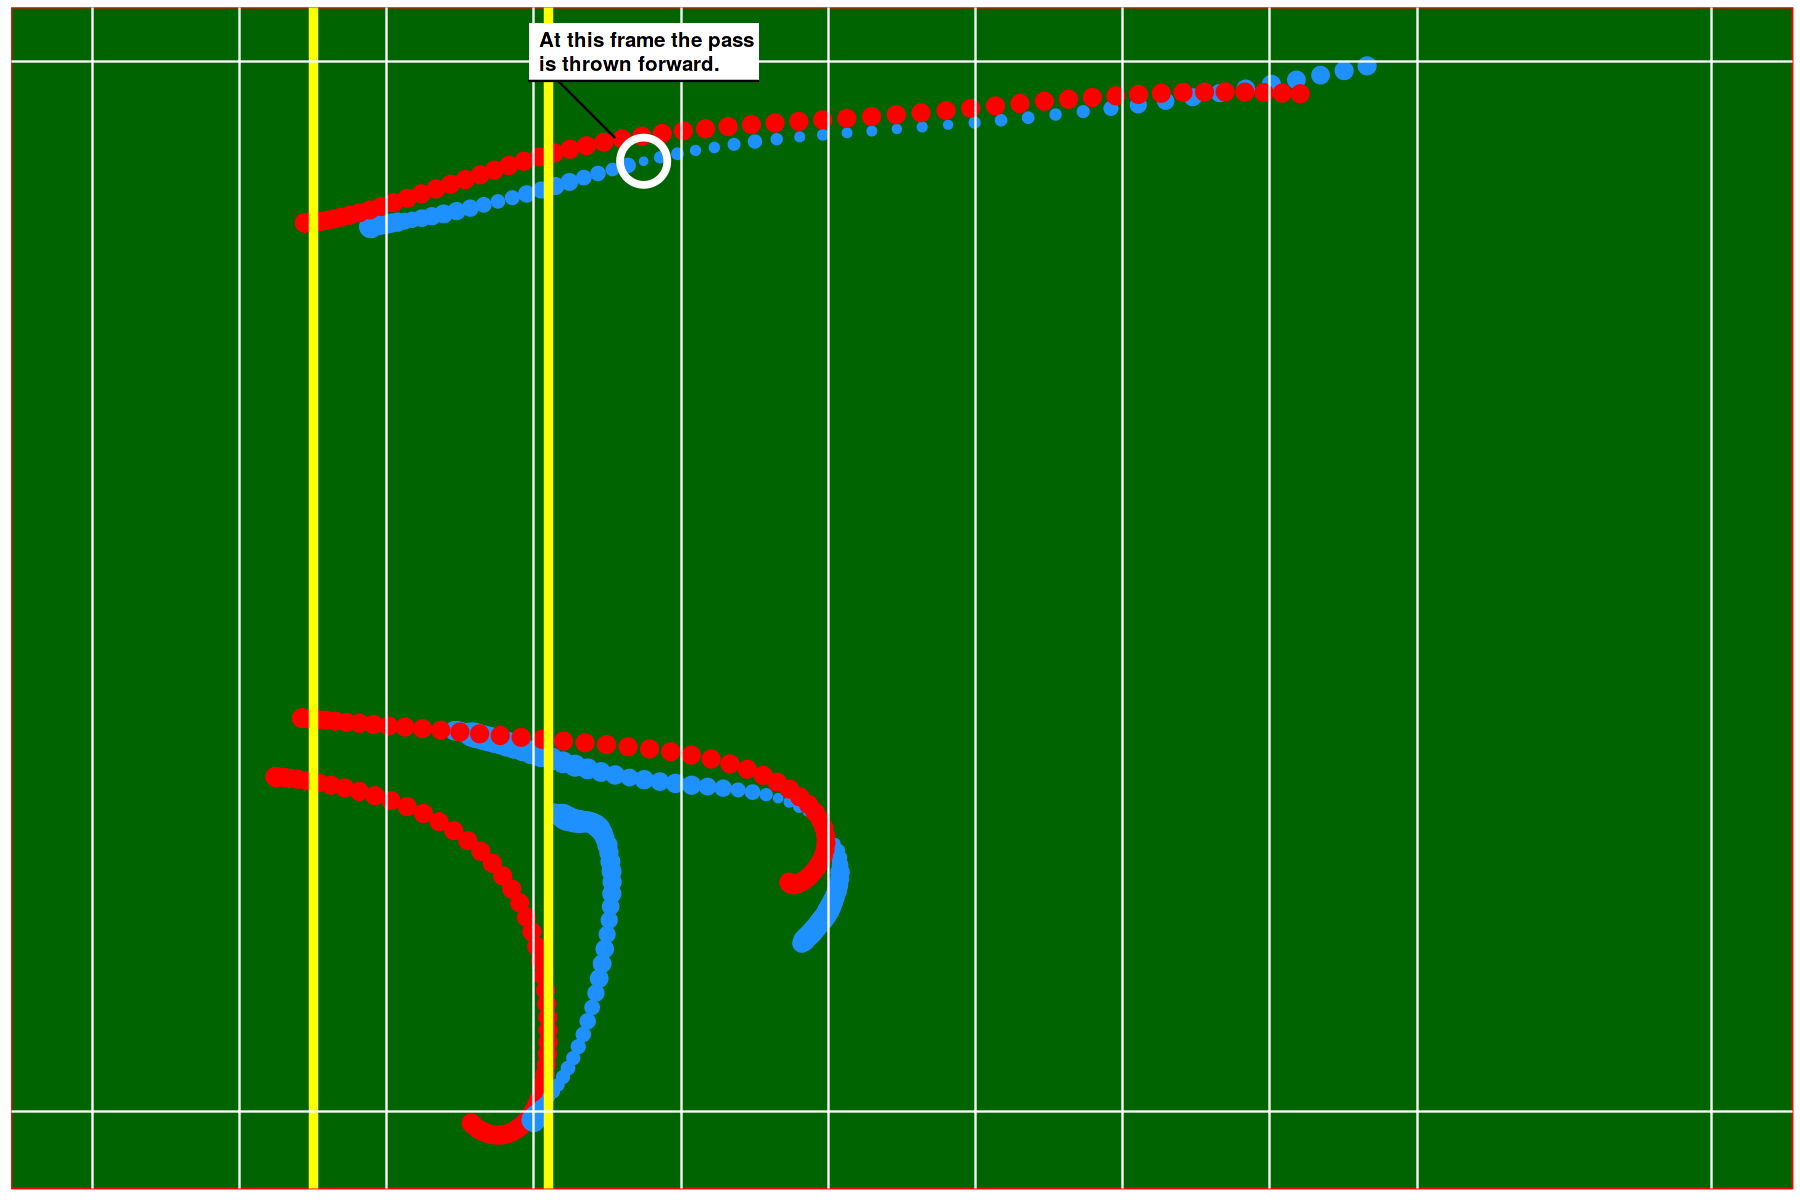

In [3]:
library(ggforce)
library(ggrepel)
library(ggthemes)
plot %>%

filter(position %in% c('WR', 'CB', 'DB')) %>%

mutate(comp_prob = if_else(is.na(comp_prob), .5, comp_prob)) %>%

ggplot(aes(x=x, y=y, col=team, size=comp_prob/3)) +
geom_point() +
theme_map() +
scale_color_manual(values=c('red', 'dodgerblue')) +
geom_vline(xintercept = 72.5, col='yellow', size=2) +
geom_vline(xintercept = 80.5, col='yellow', size=2) +
theme(legend.position = 'none',
      panel.background = element_rect(fill='darkgreen', colour='red'),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      axis.title = element_blank(),
      axis.text = element_blank(),
      axis.ticks =  element_blank(),
      plot.title = element_text(size = 12)) + 
geom_hline(yintercept=0, colour = 'white') +
geom_hline(yintercept=53.3, colour = 'white') +
geom_vline(xintercept = 65, colour = 'white') +
geom_vline(xintercept = 70, colour = 'white') +
geom_vline(xintercept = 75, colour = 'white') +
geom_vline(xintercept = 80, colour = 'white') +
geom_vline(xintercept = 85, colour = 'white') +
geom_vline(xintercept = 90, colour = 'white') +
geom_vline(xintercept = 95, colour = 'white') +
geom_vline(xintercept = 100, colour = 'white') +
geom_vline(xintercept = 105, colour = 'white') +
geom_vline(xintercept = 110, colour = 'white') +
geom_vline(xintercept = 120, colour = 'white') +
geom_mark_circle(aes(filter = event == 'pass_forward' & displayName == 'Malcolm Butler',
                   description = 'At this frame the pass is thrown forward.'),
               color = "white", label.fontface = "bold")

Here are two key features at work in this play. The black line represents the vertical distance between Butler and Fuller, the blue line is the difference in speed. On a go route, these are two vital attributes to analyze. After the ball is thrown Butler is able to ramp up his speed to match Fuller despite Fuller gaining vertical distance down the field throughout the course of the play. As Fuller's speed, acceleration, and direction of motion become clear throughout his route Butler never falls behind.

Butler puts tremendous pressure on QB DeShaun Watson to lead his receiver downfield, else Butler is running stride for stride to throw his hand up and knock down the pass.


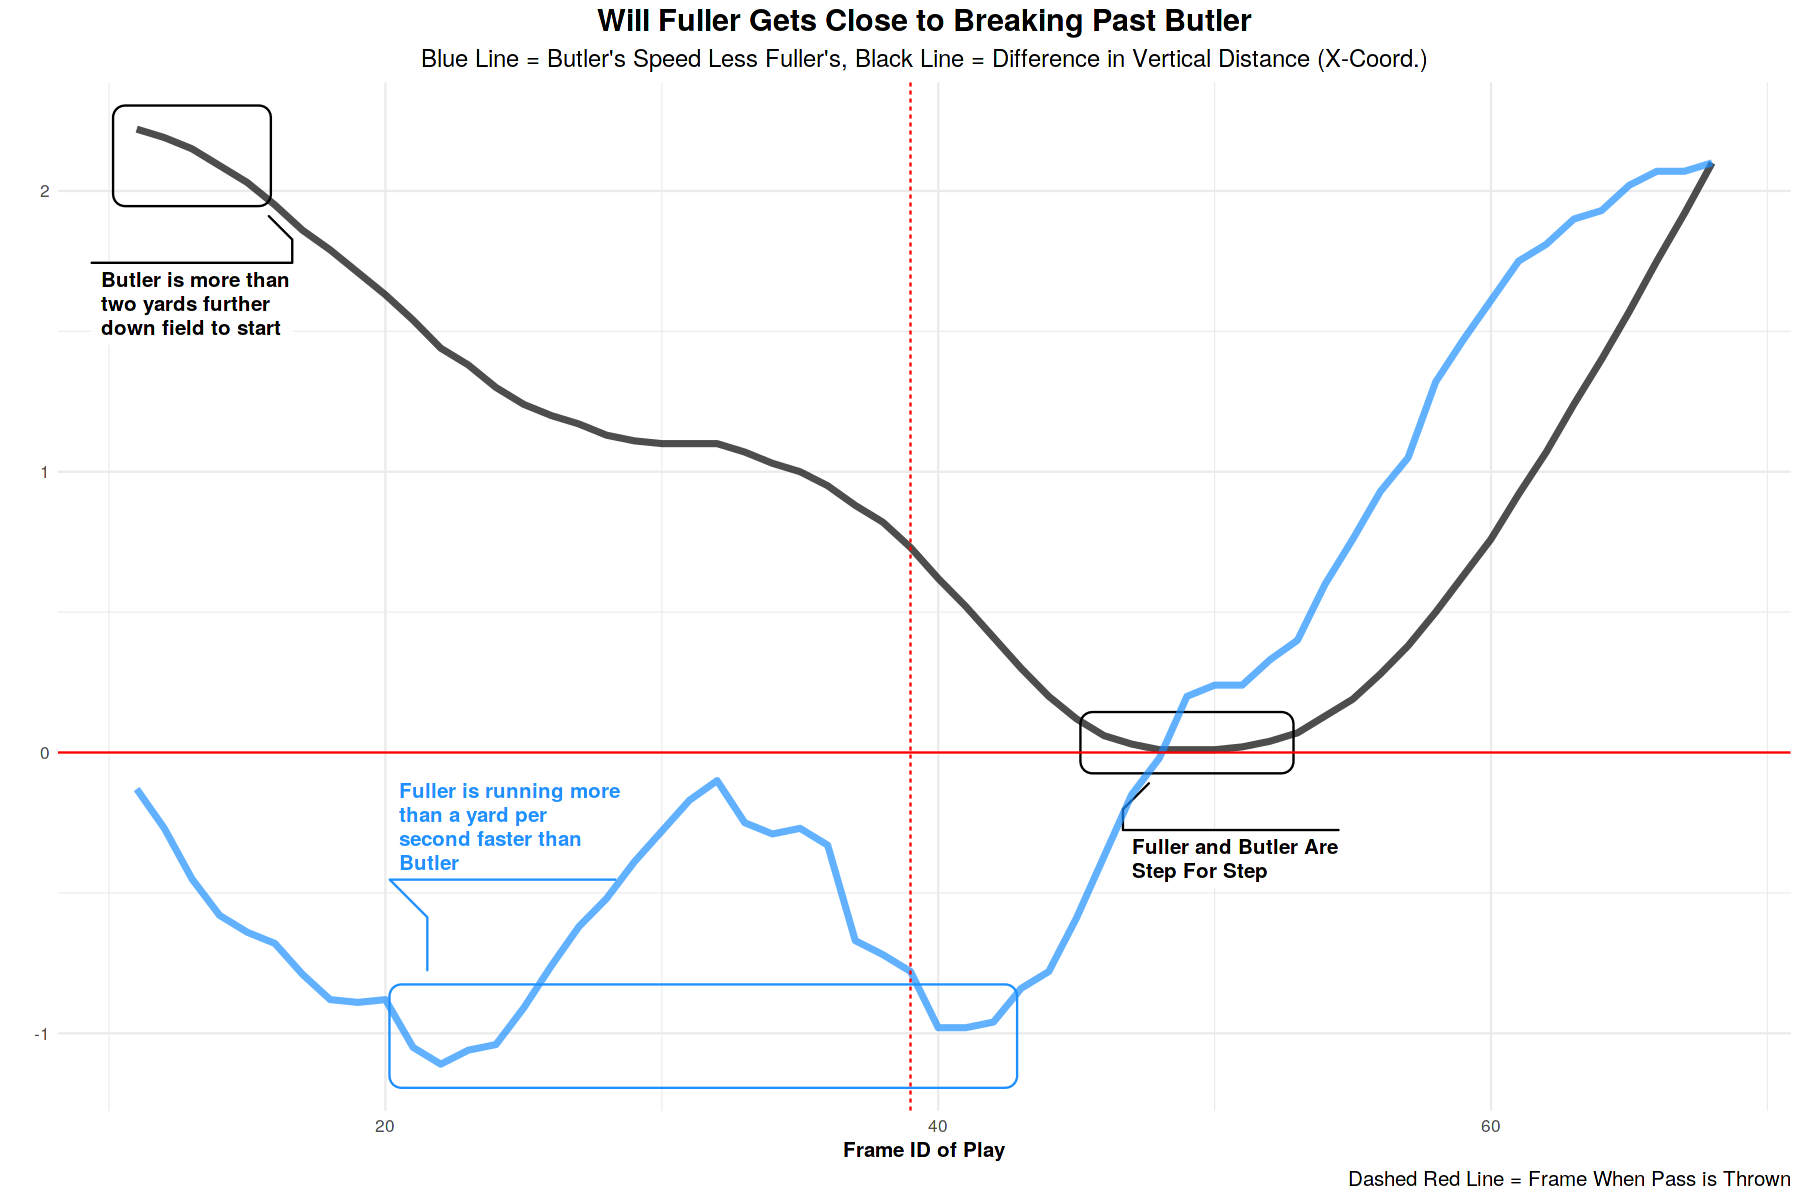

In [4]:
butler_sum_1 <- fread('../input/results/butler_sum_1.csv',
                     drop='V1')

butler_sum_1 %>%

ggplot(aes(x=frameId)) +
geom_line(aes(y=receiver_behind_db), size=1.5, alpha=.7) +
geom_mark_rect(aes(y=receiver_behind_db,
                   filter = frameId %in% seq(46, 52),
                   description = 'Fuller and Butler Are Step For Step'),
               color = "black", label.fontface = "bold", label.colour = "black", con.colour = "black") +
geom_mark_rect(aes(y=receiver_behind_db,
                   filter = receiver_behind_db > 2 & frameId < 50,
                   description = 'Butler is more than two yards further down field to start'),
               color = "black", label.fontface = "bold", label.colour = "black", con.colour = "black") +
geom_line(aes(y=diff_in_speed), col='dodgerblue', size=1.5, alpha=.7) +
geom_mark_rect(aes(y=diff_in_speed,
                   filter = diff_in_speed < -.9,
                   description = 'Fuller is running more than a yard per second faster than Butler'),
               color = "dodgerblue", label.fontface = "bold", label.colour = "dodgerblue", con.colour = "dodgerblue") +
labs(title = "Will Fuller Gets Close to Breaking Past Butler",
    x='Frame ID of Play',
    y="",
    subtitle = "Blue Line = Butler's Speed Less Fuller's, Black Line = Difference in Vertical Distance (X-Coord.)",
    caption = 'Dashed Red Line = Frame When Pass is Thrown') +
geom_hline(yintercept = 0, col='red') +
geom_vline(xintercept = butler_sum_1$frameId[which(butler_sum_1$event == 'pass_forward')], linetype='dashed', col='red') +
theme_minimal() +
theme(
    axis.title = element_text(size = 12, face='bold'),
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 12),
    legend.position = 'none'
  )

# Results

Using this method we can see which defensive backs minimized the likelihood of a pass being completed when they're covering the targeted receiver. This allows us to directly compare the observed rate of allowing completions to the expected rate.

To analyze the top corners I want to ensure two things: 1) the defender actually has to cover on the play, and 2) the receiver we're attributing the defender's assignment to (the nearest receiver) is actually part of his job on that play.

I addressed these concerns by only looking at plays where there were at least 1.5 seconds from snap to throw, and only considering snaps where the defender spent at least one-third of his time nearest to the final receiver he was closest to. This allows my analysis to eliminate some concerns regarding false attribution of responsibility.

In the plot below a few familiar names stand out as the best performers; Stephon Gilmore, Byron Jones, Darius Slay, Jaire Alexander, and other well-known names. The bottom left corner is not without a few surprises. Namely, Nevin Lawson and Steven Nelson stand out.
This plot displays the relationship between the expected completion percentage (xComp) and the actual completion percentage allowed when covering the targeted receiver.


`geom_smooth()` using formula 'y ~ x'



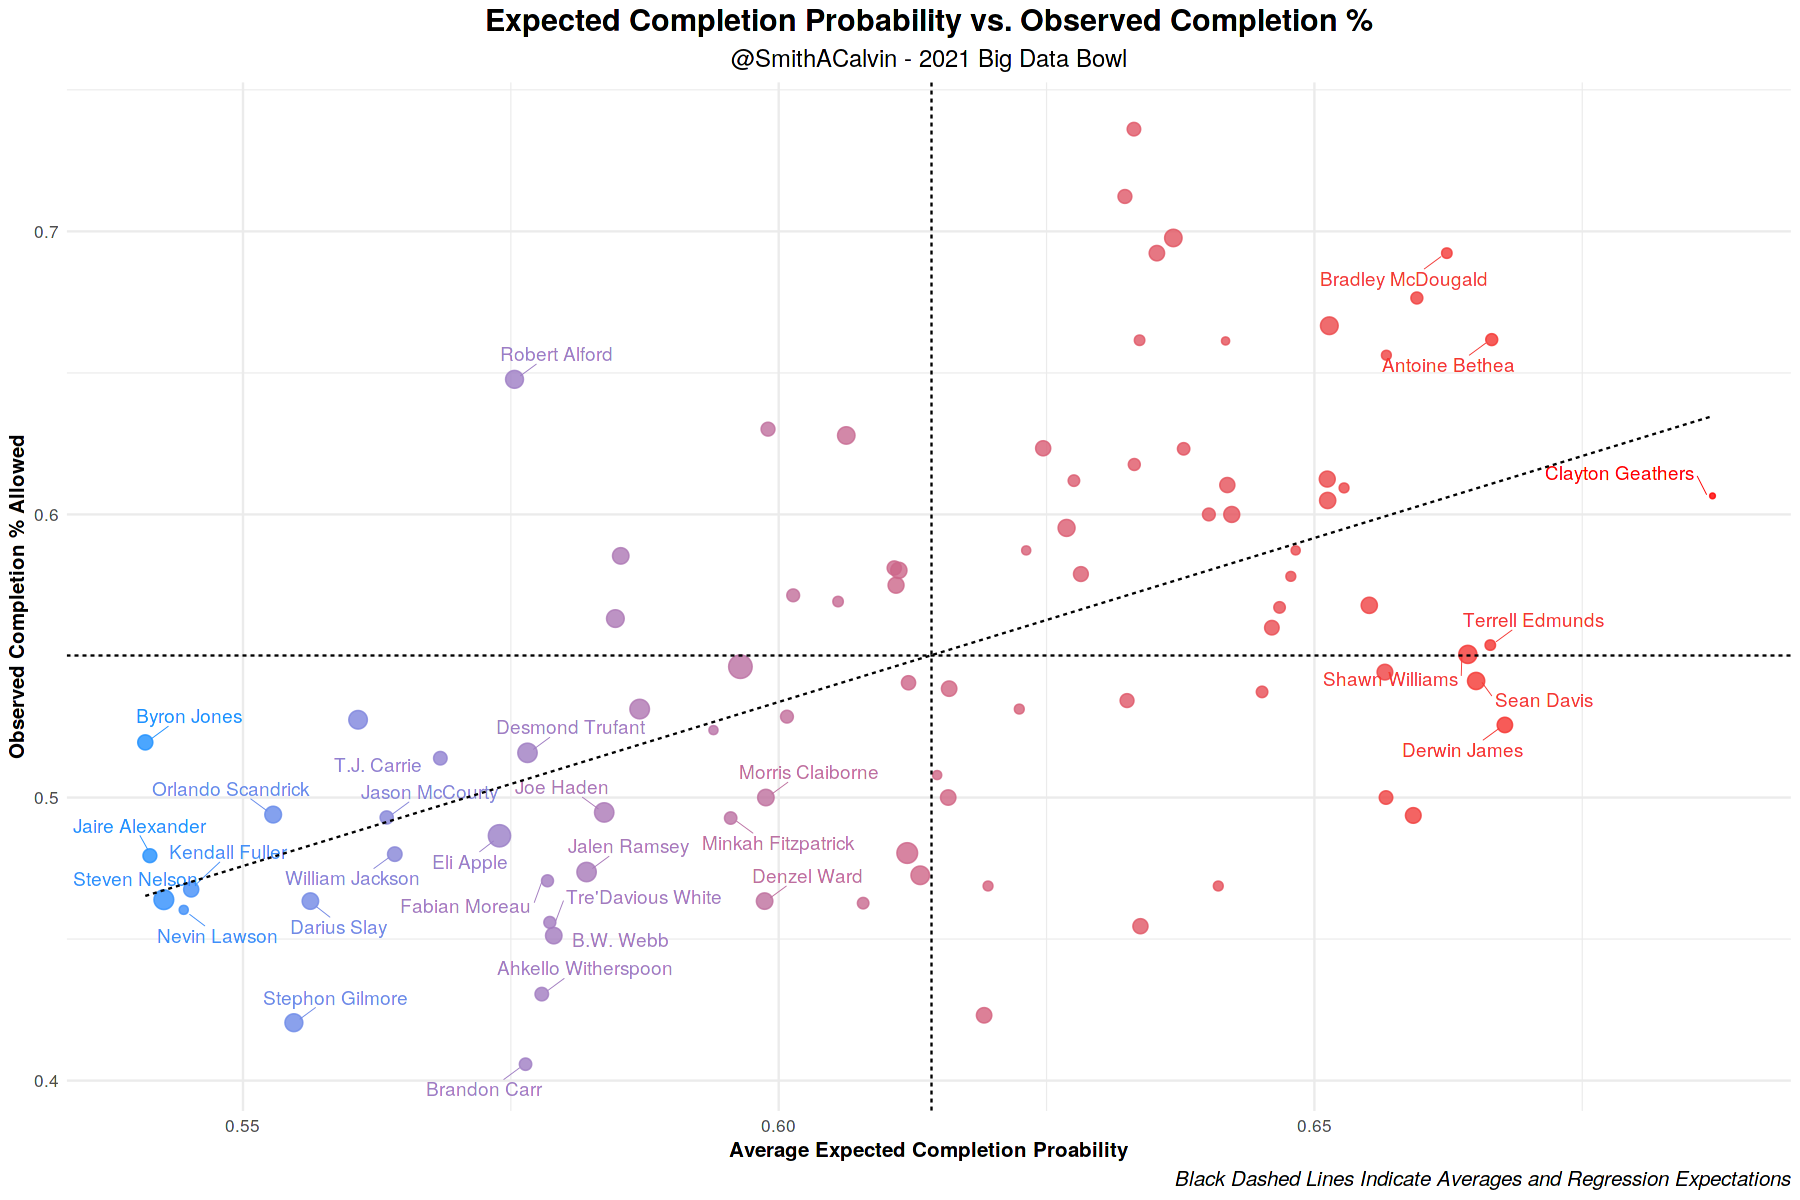

In [5]:
ct_full <- fread('../input/results/ct_agg.csv', drop='V1')
ct_full %>%

ggplot(aes(x=avg_comp_prob_ct, y=avg_ob_comp_pct, col=avg_comp_prob_ct)) +
geom_point(aes(size = num_snaps_ct), alpha = 0.8) +
geom_text_repel(data = filter(ct_full, (avg_comp_prob_ct < .6 & avg_ob_comp_pct < .52) |
                             avg_comp_prob_ct > .66 | (avg_comp_prob_ct < .6 & avg_ob_comp_pct > .645)),
                aes(label = displayName), force = 1, point.padding = 0.5,
                segment.size = 0.2) + 
theme_minimal() +
geom_vline(xintercept = mean(ct_full$avg_comp_prob_ct), col='black', linetype='dashed') +
geom_hline(yintercept = mean(ct_full$avg_ob_comp_pct), col='black', linetype='dashed') +
geom_smooth(method='lm', col='black', se=FALSE, linetype='dashed', size=.5) +
scale_color_gradient(low='dodgerblue', high='red') +
labs(title = 'Expected Completion Probability vs. Observed Completion %',
    subtitle = '@SmithACalvin - 2021 Big Data Bowl',
    x = 'Average Expected Completion Proability',
    y = 'Observed Completion % Allowed',
    caption = 'Black Dashed Lines Indicate Averages and Regression Expectations') +
theme(
    axis.title = element_text(size = 12, face='bold'),
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 12, face='italic'),
    legend.position = 'none'
  )

What makes the elite players better is how they continue to minimize completion probability at a high level after the pass is thrown. The best corners are the best at seeing the QB load up to throw and react as fast as possible to be in position.

This scatter indicates which corners break best on the ball based on the defender's gain in completion probability. Defender gain is calculated as:

xComp when pass is thrown - xComp when pass arrives

Therefore, a higher number is better. The defender's positioning at the time of arrival is the most critical data point as it is the moment of truth for the pass. These two instances aren't indicative of coverage throughout the play, but provide signal for who ends up in an optimal place.


`geom_smooth()` using formula 'y ~ x'



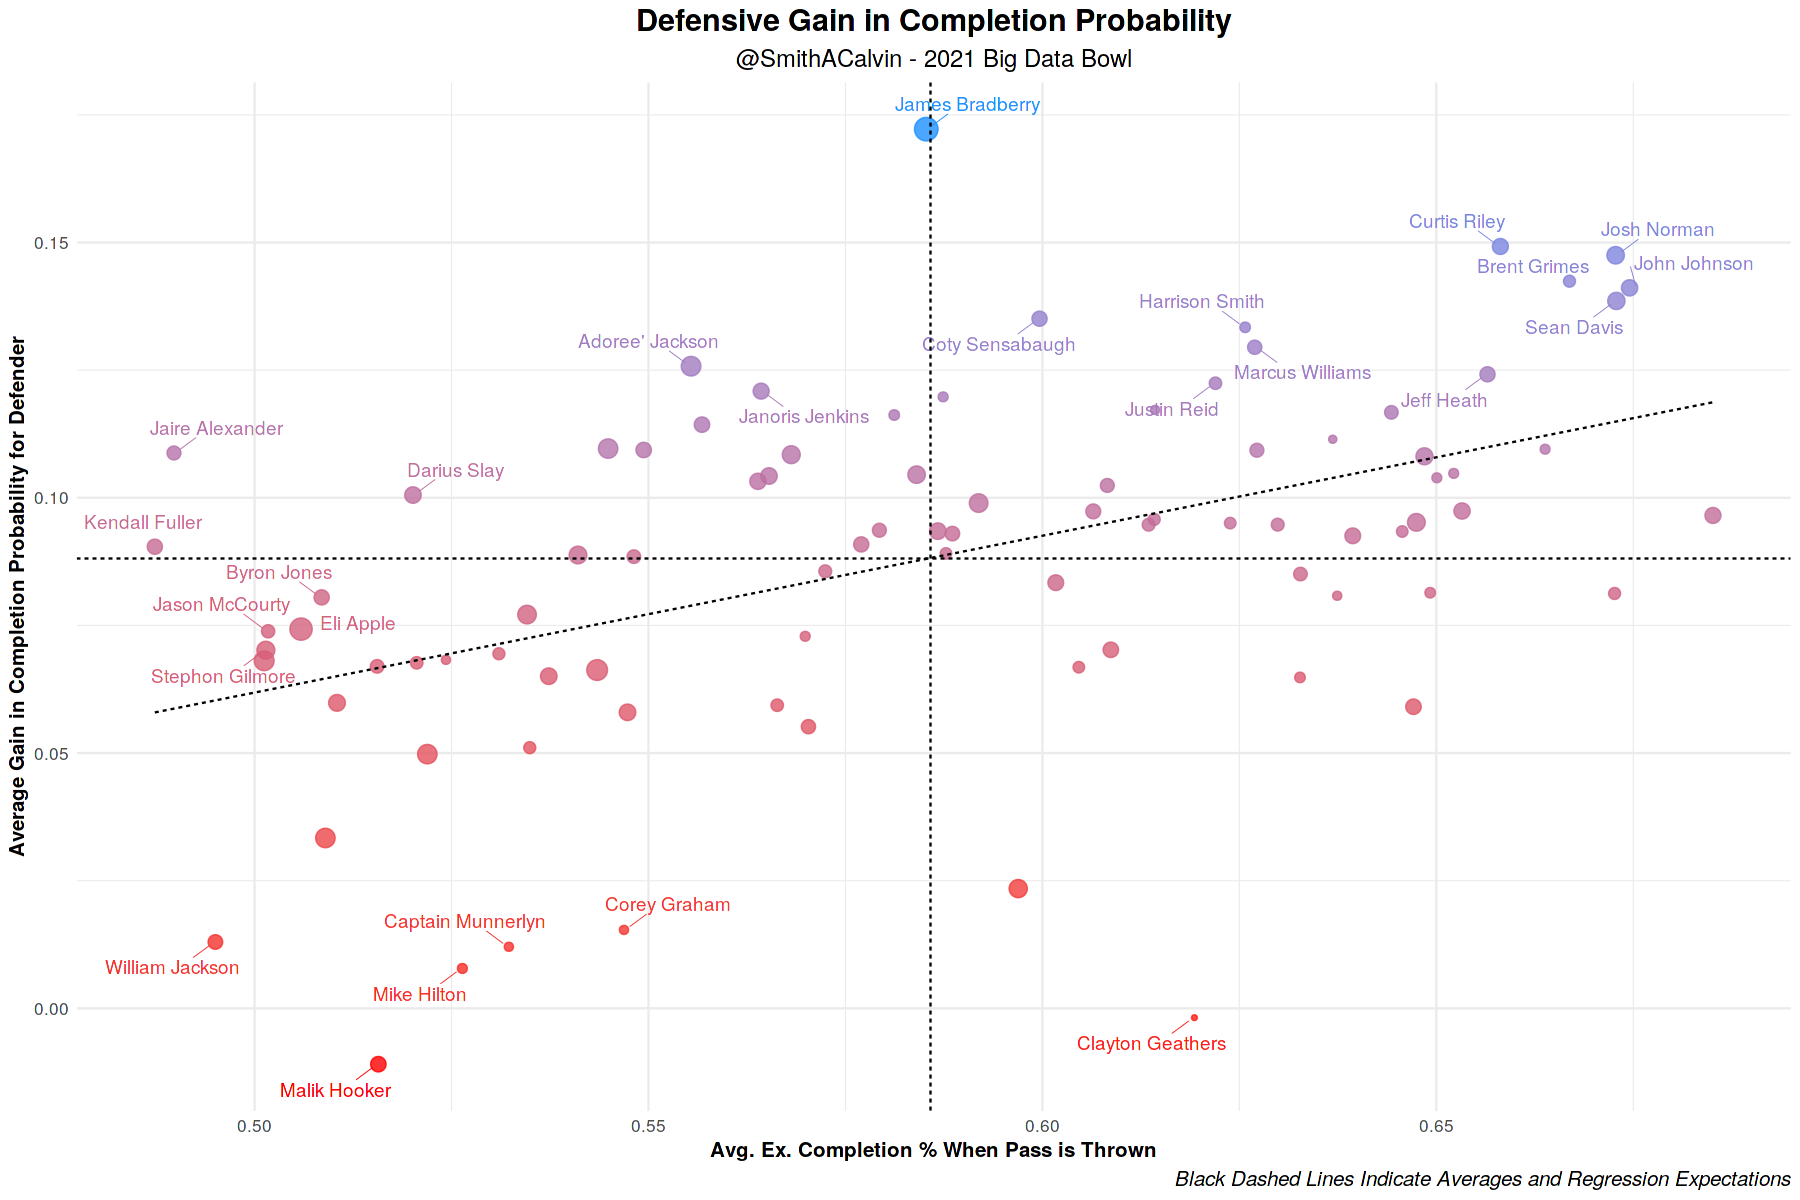

In [6]:
ct_full %>%

ggplot(aes(x=avg_pf_cp, y=avg_gain, col=avg_gain)) +
geom_point(aes(size = num_snaps_ct), alpha = 0.8) +
geom_text_repel(data = filter(ct_full, (avg_pf_cp < .53 & avg_gain > .07) |
                             avg_gain < .02 | avg_gain > .12),
                aes(label = displayName), force = 1, point.padding = 0.5,
                segment.size = 0.2) + 
theme_minimal() +
geom_vline(xintercept = mean(ct_full$avg_pf_cp), col='black', linetype='dashed') +
geom_hline(yintercept = mean(ct_full$avg_gain), col='black', linetype='dashed') +
geom_smooth(method='lm', col='black', se=FALSE, linetype='dashed', size=.5) +
scale_color_gradient(low='red', high='dodgerblue') +
labs(title = 'Defensive Gain in Completion Probability',
    subtitle = '@SmithACalvin - 2021 Big Data Bowl',
    x = 'Avg. Ex. Completion % When Pass is Thrown',
    y = 'Average Gain in Completion Probability for Defender',
    caption = 'Black Dashed Lines Indicate Averages and Regression Expectations') +
theme(
    axis.title = element_text(size = 12, face='bold'),
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 12, face='italic'),
    legend.position = 'none'
  )

After the ball is thrown is when a corner in zone or a lurking safety has his opportunity to shine. As he sits back, surveying the field and reading the Quarterback's eyes he is most prepared to drive down the odds of a completion given the nature of his role in zone coverage. An example of this is Josh Norman leading in breaking on the ball.

An advantage of this method is scalability to plays where a defender is not covering the target. Assuming the ball will be thrown to the receiver nearest to a defender the expected probability can still be calculated throughout the course of the play until the pass goes forward.

The relationship between a defender's expected completion probability when covering a target compared to when he is not covering the target is fairly strong. A regression corresponding to the plot below carries an R-Squared value of .77.


In [7]:
comp_ct_overall <- fread('../input/results/comp_ct_overall.csv', drop='V1')
suppressMessages(library(plotly))
suppressMessages(library(htmlwidgets))
suppressMessages(library(IRdisplay))
dir.create(file.path("plots/"), showWarnings = FALSE)
p <- comp_ct_overall %>%

ggplot(aes(x=avg_comp_prob_ct, y=avg_comp_prob, col=avg_comp_prob_ct, text=displayName)) +
geom_point(aes(size = num_snaps_ct), alpha = 0.8) +
stat_smooth(method='lm', col='black', se=FALSE, linetype='dashed', size=.5) +
# geom_text_repel(data = filter(comp_ct_overall, (avg_comp_prob_ct < .6 & avg_comp_prob < .6) |
#                              avg_comp_prob > .66),
#                 aes(label = displayName), force = 1, point.padding = 0.5,
#                 segment.size = 0.2) + 
theme_minimal() +
# geom_vline(xintercept = mean(ct_full$avg_comp_prob_ct), col='black', linetype='dashed') +
# geom_hline(yintercept = mean(ct_full$avg_comp_prob), col='black', linetype='dashed') +
scale_color_gradient(low='dodgerblue', high='red') +
labs(title = 'xComp While Covering the Target vs. Overall xComp',
    subtitle = 'Hover Mouse Over Dot For Player Name - @SmithACalvin',
    x = 'Average Expected Completion Proability (Covering Target)',
    y = 'Average Expected Completion Probability',
    caption = 'Black Dashed Lines Indicate Averages and Regression Expectations') +
theme(
    axis.title = element_text(size = 8, face='bold'),
    axis.text = element_text(size = 8),
    plot.title = element_text(size = 12, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 10, hjust = 0.5),
    plot.caption = element_text(size = 8, face='italic'),
    legend.position = 'none'
  )

p <- ggplotly(p, tooltip='text')

f <-"plots/plot2.html"
saveWidget(p, file.path(normalizePath(dirname(f)),basename(f)))
display_html('<iframe src="plots/plot2.html" align="center" width="90%" height="450" frameBorder="0"></iframe>')

`geom_smooth()` using formula 'y ~ x'



Considering the minimization of xComp throughout the entire play, the ability of a defender to lessen xComp through his break on the ball, and ultimately be in the best spot when the ball arrives paints a clearer picture of the top defensive backs. This can be seen in the upcoming table.

# Application

This model is relevant to NFL teams in a multitude of ways. Coaching staffs can better understand their player's tendencies, a front office can glean more information on a prospective free agent, and aid in player valuations in free agency.

For instance, a team can evaluate how effective a defensive back is when showing press coverage by evaluating plays where the defender was positioned face-to-face with and oriented toward the receiver at the time of the snap.

Showing press coverage can be defined as instances where the defender is within two yards of his nearest receiver and the line of scrimmage and facing the receiver (as shown in [Joe Andruzzi's notebook here](https://www.kaggle.com/jdruzzi/pass-coverage-classification-80-recall)).

Week-to-week this is able to help a coaching staff put players in positions where they are succeeding most often, or when a General Manager knows his defense will jam at the snap often he can target a DB who is effective when showing that look.

This process can be applied to a variety of scenarios based on the context a staff is trying to uncover as the majority of scenarios are able to be derived from the tracking data.

Take a look at the chart below which displays some well-known DB's attributes. This can help find a defender who fits an evaluator's criteria, spot tendencies, and determine who the best defenders are in different areas with team specific needs in mind.

In [8]:
table <- fread('../input/results/table.csv', drop='V1')
df <- table %>%

filter(Name == 'Jalen Ramsey' | Name == 'Stephon Gilmore' | Name == 'Malcolm Butler')
library(reshape2)
df <- melt(df, id.vars='Name')
library(ggpubr)


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


The following object is masked from ‘package:tidyr’:

    smiths




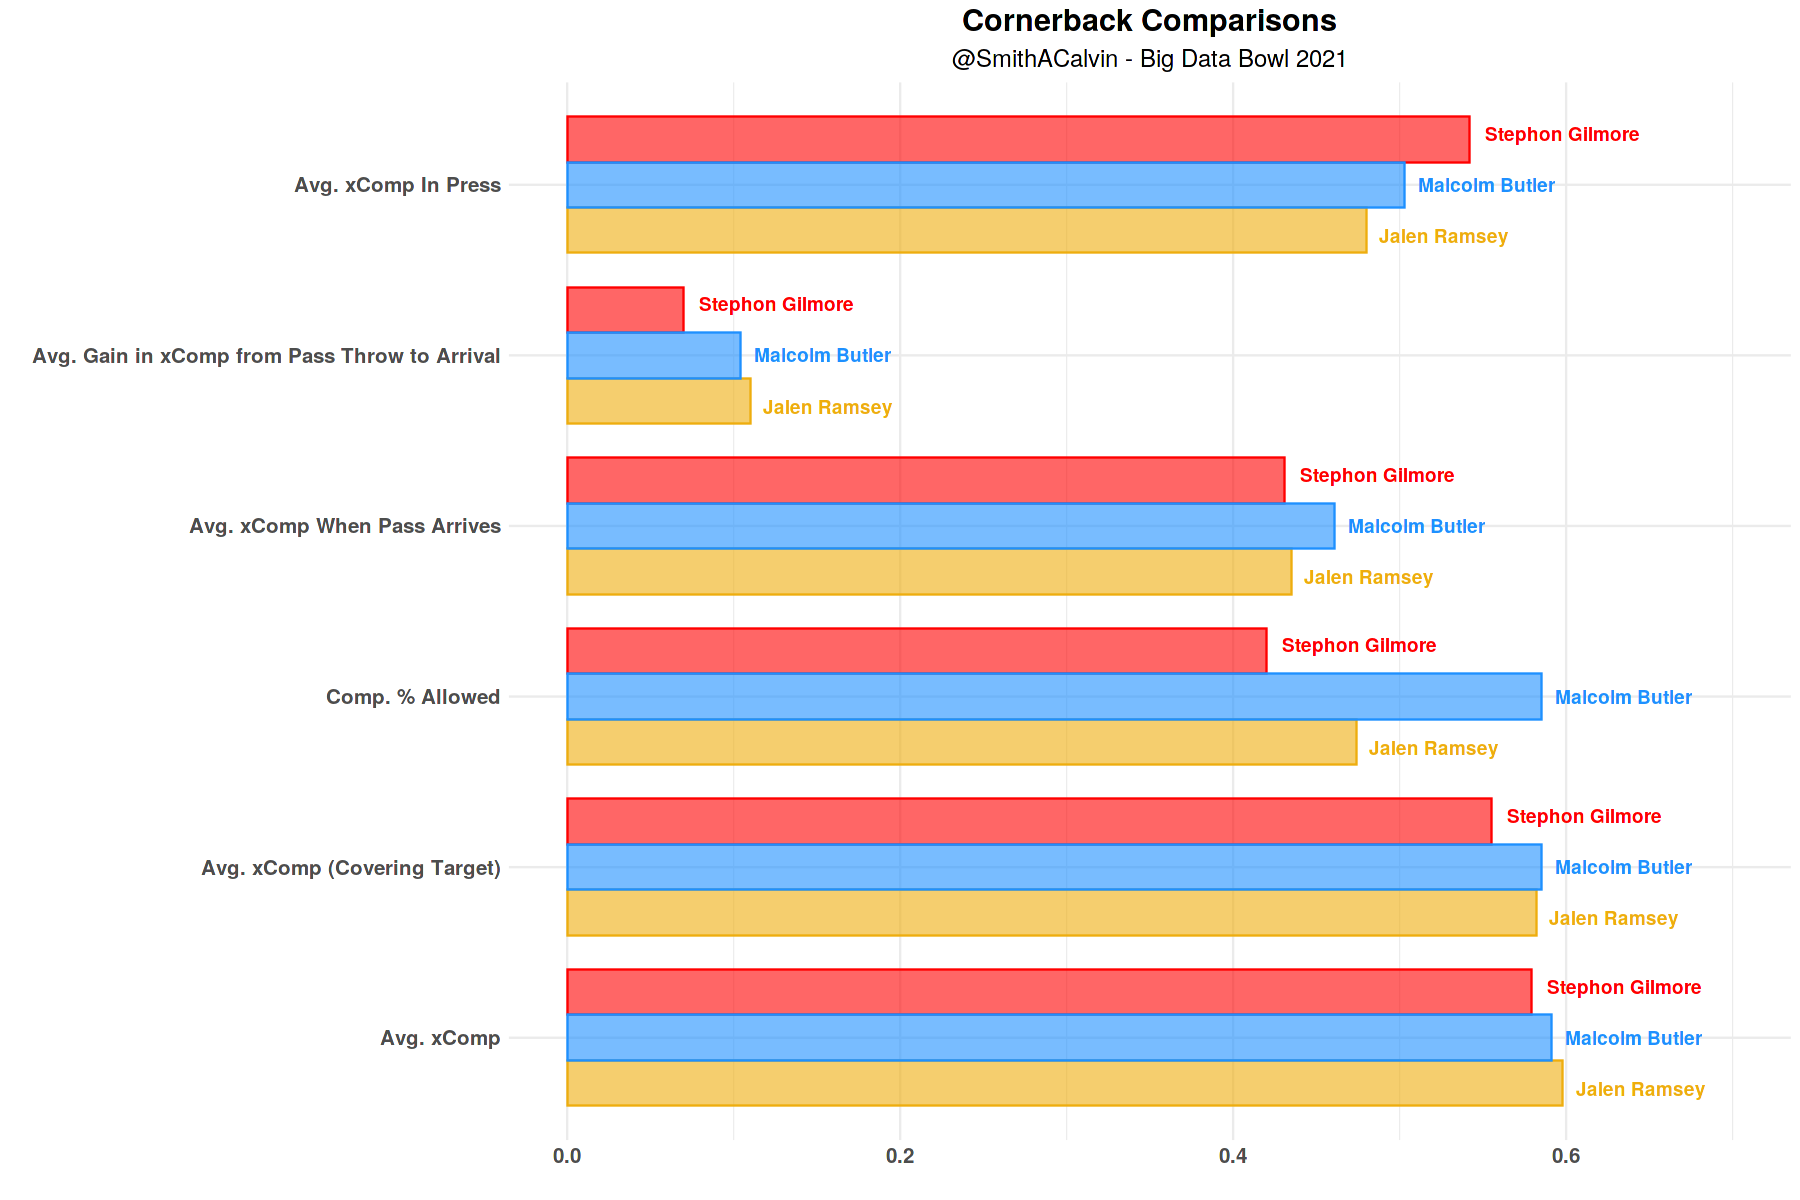

In [9]:
df %>%
  ggplot(aes(x = value, y = variable, col=Name, fill=Name)) +
  geom_col(width = 0.8, alpha=.6, stat='identity', position='dodge') +
  theme_minimal() +
  geom_hline(yintercept = 0) +
  labs(y='',
      x='',
      title='Cornerback Comparisons',
      subtitle='@SmithACalvin - Big Data Bowl 2021') +
  geom_text(aes(label=Name), hjust=-.1, position = position_dodge(0.9),
           fontface='bold') +
theme(axis.title = element_text(size = 10, face='bold'),
    axis.text = element_text(size = 12, face='bold'),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 8, face='italic'),
    legend.position = 'none') +
xlim(0, .7) +
scale_color_manual(values = c('darkgoldenrod2', 'dodgerblue', 'red')) +
scale_fill_manual(values = c('darkgoldenrod2', 'dodgerblue', 'red'))

In player valuation efforts this can aid a front office in determining whether or not a good season was a fluke or not. Take Brandon Carr for example, after filtering he had the best-observed completion percentage allowed. But, his xComp was substantially higher than his observed. This was followed by more than 4% increase in his observed completion percentage from 2018 to 2019.

A front office ought to be less likely to pay a defensive back who's performance likely won't be repeated.

# Conclusions and Future Work

Stephon Gilmore, Jaire Alexander, and Byron Jones are among the well-known names whose xComp stood out in 2018. In order to fulfill all of the assumptions made in this analysis, I'd like to able to test the year-over-year stability of xComp and test the extent to which it is indicative of regression to the mean in completion percentage allowed. If combined with a coverage identification model this analysis could be even more valuable in identifying player strengths and weaknesses. Alongside attributes like xComp in press, xComp against speed receivers, and a variety of other relevant situations a team would be able to leverage troves of data to put defenders in the best situation in-game and sign the optimal fit for their scheme.